# lab12 - st121413

## In-lab exercises

1. Spend some time to understand the Transformer and Speech Recognition examples.
 - I did this in the main_\[modelname\].py and save the best model in /checkpoint for the next one
 - https://github.com/akraradets/2021JanRTML/tree/main/lab12
2. After training, test the two models on some data (text, audio) you provide yourself

## Transformer

In [1]:
from torchtext.data.utils import get_tokenizer
from myTransformer import *
from utils import *
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = get_tokenizer('basic_english')
vocab = load_vocab('checkpoint/transformer_vocab.pickle')
batch_size = 10
def data_process(raw_text_iter, vocab, tokenizer):
    data = [torch.tensor([vocab[token] for token in tokenizer(item)], dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

bptt = 35
text = "Visual Studio Code is a lightweight yet full featured cross platform IDE for software development that has recently caught up in terms of capabilities and popularity with other popular IDEs for Python such as PyCharm. It is reputed to be easier to configure and use, also. We'll give it a try this semester."
text_tensor = data_process(text, vocab, tokenizer)
text_batch = batchify(text_tensor, batch_size)

In [2]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
model.load_state_dict(torch.load('checkpoint/transformer.pth'))
model.to(device)
criterion = nn.CrossEntropyLoss()
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

test_loss = evaluate(model, text_batch)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(test_loss, math.exp(test_loss)))

| End of training | test loss  8.54 | test ppl  5110.08


## Speech Recognition

In [ ]:
# !pip3 install pydub

tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([89908])


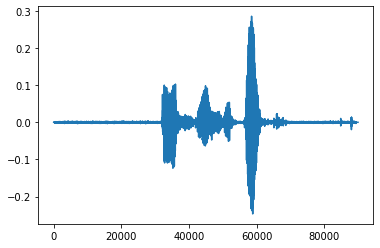

In [70]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torchaudio
import numpy as np
info = mediainfo("./data-speech/myTest.m4a")
audio = AudioSegment.from_file('./data-speech/myTest.m4a')
waveform = torch.from_numpy(np.array(audio.get_array_of_samples() ) ).T / (2 ** 16)
downsample = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq = int(info['sample_rate']), new_freq = 16000),
    )
print(waveform)

waveform = downsample(waveform)
print(waveform.shape)
sample_rate = 16000
plt.plot(waveform)
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [71]:
import torchaudio
kwargs = {'num_workers': 1, 'pin_memory': True} if 'cuda:0' else {}
data = [(waveform, "THIS IS A BOOK")]

def data_processing(data):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, utterance,) in data:
        spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

test_loader = torch.utils.data.DataLoader(dataset=data,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x),
                            **kwargs)

In [73]:
from texttransform import TextTransform
from myDeepSpeech import *
from utils_speech import *

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
    }
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

valid_audio_transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    )




/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [81]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

def test(model, device, test_loader, criterion):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    return test_loss


text_transform = TextTransform()
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    )
model.load_state_dict(torch.load('checkpoint/deepspeech.pth',map_location='cpu'))
model.to(device)

criterion = nn.CTCLoss(blank=28).to(device)
loss = test(model, device, test_loader, criterion)




evaluating...
Test set: Average loss: 4.1068, Average CER: 0.928571 Average WER: 1.5000



## Homework

Since you're all extremely busy with your projects (RIGHT??), for the homework for this week,
write an explanation of the steps that would be needed to adapt the PyTorch transformer to
the speech recognition task. Be specific in how you would do the implementation, but you do
not need to ac

To repliacte the task of Deep Speech 2, the transformer need to be able to take spectrogram as an input.

I would copy the first three layers from Deep Speech (CNN, rescnn, fully_connected).
Then, I would copy the forward function from the Deep Speech 2 up to the fully connected layer.

        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)

At this point, the transformer should be able to extract the feature from spectrogram.

Feed these feature into the positionalEncoder and proceed the transformer stuff.